In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
#from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import robust_scale, scale, minmax_scale, quantile_transform
from scipy import stats
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

 <font size="5"> portfolio </font>

Splitting the channel feature apart.

All channels contain 'email' so it wont be informative. Removing it makes things clearer and also it is good to cut down on features that dont contain useful information before building our model.

In [3]:
for row in portfolio.channels:
    row.remove('email')
    

In [4]:
channels = pd.DataFrame(portfolio.pop('channels'))

Steps below almost work likes a one hot encoding for nested values.


explode behaves like an ungrouping

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html

In [5]:
channels = channels.explode('channels')


In [6]:
channels = channels.assign(value= 1)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html

In [7]:
channels=channels.pivot(columns='channels', values='value')

In [8]:
channels.fillna(value=0, inplace=True)

In [9]:
portfolio = portfolio.join(channels)
del channels

In [10]:
#function to one hot encode a field and join to its table
#def one_hot(df,col):
#    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
#    df=df.drop(columns=col,axis=1)
#    return df

In [11]:
#function to one hot encode a field and join to its table (same result as above)
def one_hot(df,col):
    df = df.join(pd.get_dummies(df.pop(col),prefix=col))
    return df



In [12]:
portfolio=one_hot(portfolio,'offer_type')
portfolio

,reward,difficulty,duration,id,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,0.0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,0.0,1.0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,0.0,1.0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,1.0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,0.0,1.0,0,1,0


 <font size="5"> profile </font>

filtering out bad data from profile.  

in the data exploration notebook we discovered all rows where age=118 are also the same rows where both gender and income are null. So I will remove those rows.

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile=profile[profile['age']!= 118]
profile.count()

gender              14825
age                 14825
id                  14825
became_member_on    14825
income              14825
dtype: int64

became_member_on needs to be converted to a number so we can then normalise it.

In [15]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [16]:

profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [17]:
profile['became_member_on']=profile['became_member_on'].view('int')

In [18]:
profile=profile[profile['age']!= 118]

In [19]:
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,1524700800000000000,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,1518134400000000000,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,1510358400000000000,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,1528070400000000000,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,1531440000000000000,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,1485388800000000000,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,1457308800000000000,50000.0


In [20]:
#pd.DataFrame(profile['became_member_on']) 
#is the same as
#profile.filter(['became_member_on'])

In [21]:
#could have used quantile_transform for some values

#also could have used an update at the end instead of popping and joining
#profile.update(became_mem)

Robust Scaler: similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.  
Robust Scaler: doesn't take the median into account and only focuses on the parts where the bulk data is.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.robust_scale.html

Standardization: scales features such that the distribution is centered around 0, with a standard deviation of 1.  
Standardization: not good if the data is not normally distributed (i.e. no Gaussian Distribution).  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

Quantile Scaler: This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform

Power transforms: are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html#sklearn.preprocessing.power_transform

This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale

Quantile is good for outliers  
Power is good for non-constant variance

In [22]:
def robustScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=robust_scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [23]:
def standardScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [24]:
def quantileScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=quantile_transform(col, output_distribution='normal', copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [25]:
def minMaxScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=minmax_scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

I will use robust_scale on both 'became_member_on" and "income" because the distrubition isn't that close to a normal distrubition

In [26]:
profile=quantileScale(profile,'became_member_on')

In [27]:
profile=robustScale(profile,'income')

In [28]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,-0.044921,1.548387
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,-0.138168,1.161290
5,M,68,e2127556f4f64592b11af22de27a7932,1.258508,0.193548
8,M,65,389bc3fa690240e798340f5a15918d5c,0.873515,-0.354839
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,0.430727,-0.419355


Do not use quantile_transform unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set. In general, we recommend using QuantileTransformer within a Pipeline in order to prevent most risks of data leaking:pipe = make_pipeline(QuantileTransformer(), LogisticRegression()).



I also considred using minmax_scale scaling. But I decided to just use robust_scale again because I wanted it centered around 0 like the other variables.

In [29]:
#profile=minMaxScale(profile,'age')

In [30]:
profile=robustScale(profile,'age')

In [31]:
#to get the skewed data first rerun lines above, and then run
#profile=robustScale(profile,'became_member_on')
#then run
#profile.became_member_on.hist()


array([[<AxesSubplot:title={'center':'became_member_on'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

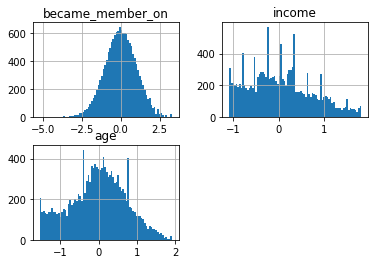

In [32]:
profile[['became_member_on','income','age']].hist(bins=80)

After looking at the graphs above I am considering a quantile transform on 'became_member_on'. It is highly skewed to the right.

<font size=3>use the one_hot encoding function from earlier on gender too.<font/>

In [33]:
profile=one_hot(profile,'gender')
profile.head()

,id,became_member_on,income,age,gender_F,gender_M,gender_O
1,0610b486422d4921ae7d2bf64640c50b,-0.044921,1.548387,0.000000,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,-0.138168,1.161290,0.833333,1,0,0
5,e2127556f4f64592b11af22de27a7932,1.258508,0.193548,0.541667,0,1,0
8,389bc3fa690240e798340f5a15918d5c,0.873515,-0.354839,0.416667,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0.430727,-0.419355,0.125000,0,1,0


 <font size="5"> transcript </font>

Preparing transcript table in the same way it was done in the Data_Exploration notebook

In [34]:
value_col=transcript.pop('value')

value_col=pd.DataFrame.from_records(data=value_col,columns=['offer id','offer_id','amount','reward'])

value_col['offer id'].update(value_col.pop('offer_id'))

transcript= transcript.join(value_col)

transcript.rename(columns={"offer id": "offer_id"},inplace=True)

display(transcript.groupby(['event']).count())

,person,time,offer_id,amount,reward
event,,,,,
offer completed,33579,33579,33579,0,33579
offer received,76277,76277,76277,0,0
offer viewed,57725,57725,57725,0,0
transaction,138953,138953,0,138953,0


In [35]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Joining portfolio to transcript as was done in data exploration

In [36]:
portfolio.rename(columns={"id": "offer_id"},inplace=True)

transcript_portfolio=transcript.merge(portfolio,on=('offer_id' ),how='left')


#Instead of removing one of the columns, I am keeping both for now
#renaming reward to reward_recieved from transcript. and reward from portfolio will be kept as reward.
transcript_portfolio.rename(columns={"reward_x": "reward_received","reward_y": "reward"},inplace=True)


transcript_portfolio.head()

,person,event,time,offer_id,amount,reward_received,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,5.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,20.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,10.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,10.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0


In [37]:

#transcript_portfolio.query('event == "offer received"')

reward and reward_receieved are identical where event==offer_completed.  
reward_received is null where event!='offer_completed'.  
So i will remove 'reward received' as it holds no additonal data that 'reward' doesnt. I am aware it only is awarded when 'offer_completed' but I would like to have the information there for the offer regardless of event.

In [38]:
#display(transcript[transcript.event=='offer received'].head(2))

#transcript_portfolio[transcript_portfolio.event=='offer completed']['reward']
#transcript_portfolio[transcript_portfolio.event=='offer completed']['reward_recieved']


In [39]:
#display(transcript[transcript.event=='offer received'].head(2))

display(transcript_portfolio[transcript_portfolio.event=='offer completed']['reward'].equals(transcript_portfolio[transcript_portfolio.event=='offer completed']['reward_received']))

display(transcript_portfolio[transcript_portfolio.event!='offer completed']['reward_received'].unique())

transcript_portfolio.drop(['reward_received'], axis=1, inplace=True)

transcript_portfolio.head()

True

array([nan])

,person,event,time,offer_id,amount,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0


Scaling the reward, difficulty and duration to be between 0 and 1. None of them have a normal distribution, so standard scaling doesnt make sense. And I dont think robust scaling is needed as there arent any obvious outliers.

In [40]:
def minMaxScale (df,col):
    col=df.filter(col)
    col_scaled=minmax_scale(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

dont be misled by the zeros now for duration, it just min max scaled. (it is 3)

In [41]:
transcript_portfolio=minMaxScale(transcript_portfolio,(['reward','difficulty','duration']))
transcript_portfolio

,person,event,time,offer_id,amount,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.5,0.25,0.571429,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.5,1.00,1.000000,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0.2,0.50,0.571429,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0.2,0.50,1.000000,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1.0,0.50,0.285714,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
display(transcript_portfolio.groupby('amount').count().head(10))
display(transcript_portfolio.groupby('amount').count().tail(10))

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
amount,,,,,,,,,,,,,
0.05,431,431,431,0,0,0,0,0,0,0,0,0,0
0.06,109,109,109,0,0,0,0,0,0,0,0,0,0
0.07,89,89,89,0,0,0,0,0,0,0,0,0,0
0.08,100,100,100,0,0,0,0,0,0,0,0,0,0
0.09,87,87,87,0,0,0,0,0,0,0,0,0,0
0.10,95,95,95,0,0,0,0,0,0,0,0,0,0
0.11,99,99,99,0,0,0,0,0,0,0,0,0,0
0.12,79,79,79,0,0,0,0,0,0,0,0,0,0
0.13,97,97,97,0,0,0,0,0,0,0,0,0,0


,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
amount,,,,,,,,,,,,,
947.43,1,1,1,0,0,0,0,0,0,0,0,0,0
957.15,1,1,1,0,0,0,0,0,0,0,0,0,0
961.21,1,1,1,0,0,0,0,0,0,0,0,0,0
962.10,1,1,1,0,0,0,0,0,0,0,0,0,0
966.24,1,1,1,0,0,0,0,0,0,0,0,0,0
977.78,1,1,1,0,0,0,0,0,0,0,0,0,0
989.34,1,1,1,0,0,0,0,0,0,0,0,0,0
1001.85,1,1,1,0,0,0,0,0,0,0,0,0,0
1015.73,1,1,1,0,0,0,0,0,0,0,0,0,0


In [43]:
transcript_portfolio=quantileScale(transcript_portfolio,'amount')

<AxesSubplot:>

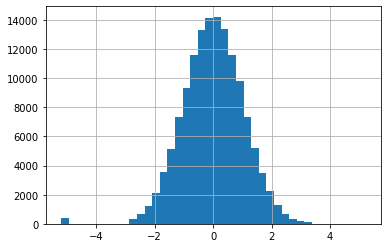

In [44]:
transcript_portfolio['amount'].hist(bins=40)

 I now feel all 3 tables are scaled, and parsed out correctly. I will be joining profile data with the other (already joined) transcript and portfolio data later.

In [45]:
profile.head()

,id,became_member_on,income,age,gender_F,gender_M,gender_O
1,0610b486422d4921ae7d2bf64640c50b,-0.044921,1.548387,0.000000,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,-0.138168,1.161290,0.833333,1,0,0
5,e2127556f4f64592b11af22de27a7932,1.258508,0.193548,0.541667,0,1,0
8,389bc3fa690240e798340f5a15918d5c,0.873515,-0.354839,0.416667,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0.430727,-0.419355,0.125000,0,1,0


In [46]:
transcript_portfolio

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.5,0.25,0.571429,1.0,0.0,1.0,1.0,0.0,0.0,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.5,1.00,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.2,0.50,0.571429,1.0,0.0,1.0,0.0,1.0,0.0,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.2,0.50,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,0.50,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.031509
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049576
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.506348
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.519225


for now, I dont think any preprocessing is needed for time. I will just use it as a guide in the next step to order the data to determine when an event happened (as that will decide whether an offer may have had an influence or not)  

and I dont intend to one hot encode events either (as I did for other categorical data) as I dont see them as variables.

<font size=5>Classifying the offers<font/>

The next important step is to determine the classes from transcript. I need to determine successful offers from unsucessful offers in order to create my model.

People who are influenced and successfully convert - effective offers:

* `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
* `offer received` -> `transaction` -> `offer viewed` -> `offer completed` (I think this works too)
* `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)


People who received and viewed an offer but did not successfully convert - ineffective offers:

* offer received -> offer viewed

People who received offers but no action taken - ineffective offers:

* offer received

 People who purchase/complete offers regardless of awareness of any offers - ineffective offers:

- transaction
- offer received -> transaction -> offer completed -> offer viewed
- transaction -> offer received -> offer completed -> offer viewed
- ##offer received -> transaction -> offer viewed -> offer completed
- offer received -> transaction (informational offers)
- offer received -> transaction ->offer viewed (informational offers)  



It is possible for the same person to get the same offer sent to them more than once as seen below.  

and actually 2 offers can be overlapping in duration. see the example where person =0009655768c64bdeb2e877511632db8f

So I will associate all transactions with the most recent event VIEWED event.

In [47]:
transcript_portfolio[transcript_portfolio.event=='offer received'].groupby(['person','offer_id']).count()

event  \
person                           offer_id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 2906b810c7d4411798c6938adc9daaa5      3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   

                                                                   time  \
person                           offer_id                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     1   
                                 3f207df678b143eea3cee63160fa8bed     1   
                                 5a8bc65990b245e5a138643cd4eb9837     1   
                                 f19421c1d4aa40978ebb69ca19b0e20d     1   
                                 fafdcd668e3743c1bb461111dcafc2a4     1   
...                                                                 ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d     2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7     1   
                                 2906b810c7d4411798c6938adc9daaa5     3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     1   
                                 fafdcd668e3743c1bb461111dcafc2a4     1   

                                                                   reward  \
person                           offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       1   
                                 3f207df678b143eea3cee63160fa8bed       1   
                                 5a8bc65990b245e5a138643cd4eb9837       1   
                                 f19421c1d4aa40978ebb69ca19b0e20d       1   
                                 fafdcd668e3743c1bb461111dcafc2a4       1   
...                                                                   ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7       1   
                                 2906b810c7d4411798c6938adc9daaa5       3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9       1   
                                 fafdcd668e3743c1bb461111dcafc2a4       1   

                                                                   difficulty  \
person                           offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5           1   
                                 3f207df678b143eea3cee63160fa8bed           1   
                                 5a8bc65990b245e5a138643cd4eb9837           1   
                                 f19421c1d4aa40978ebb69ca19b0e20d           1   
                                 fafdcd668e3743c1bb461111dcafc2a4           1   
...                                                                       ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d           2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7           1   
                                 2906b810c7d4411798c6938adc9daaa5           3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9           1   
                                 fafdcd668e3743c1bb461111dcafc2a4           1   

                                              

In [48]:
transcript_portfolio=transcript_portfolio.sort_values(['person','time'])

confirming that null values i intend to forward fill only occur for event=tranaction.  
and also confirming the amount is only populated for transactions

In [49]:
#transcript_portfolio.offer_id.isna().isin(transcript_portfolio.event == 'offer viewed').all()
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_id'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['reward'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['difficulty'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['duration'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['mobile'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['social'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['web'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_type_bogo'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_type_discount'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_type_informational'].isna()).all())

display(((transcript_portfolio['event'] != 'transaction')==transcript_portfolio['amount'].isna()).all())



True

True

True

True

True

True

True

True

True

True

True

In [50]:
transcript_portfolio.head(10)

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010382
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,0.00,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.0,0.00,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
168412,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017147
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,0.2,0.50,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,NaN


In [51]:
transcript_portfolio.columns

Index(['person', 'event', 'time', 'offer_id', 'reward', 'difficulty',
       'duration', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'amount'],
      dtype='object')

In [52]:
#no event time or amount

cols=['person','offer_id', 'reward', 'difficulty',
       'duration', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational']

forward filling  
forward filling the null values for transcations. We will now now what order_id a transaction occurs after. And if this falls within a the offer duration time window for an informational offer then we can flag it as successful.

In [53]:
#transcript_portfolio.loc[:,cols] = transcript_portfolio.loc[:,cols].groupby(['person','offer_id']).ffill()

#transcript_portfolio.loc[:,cols].groupby(['person','offer_id']).ffill()

#transcript_portfolio.update(transcript_portfolio[(transcript_portfolio.event == 'offer viewed')|(transcript_portfolio.event == 'transaction')].loc[:,cols].groupby(['person','offer_id']).ffill())

transcript_portfolio_filled=transcript_portfolio[(transcript_portfolio.event == 'offer viewed')|(transcript_portfolio.event == 'transaction')].loc[:,cols].groupby(['person']).ffill()

transcript_portfolio.update(transcript_portfolio_filled)

Spot checking my fills worked as expected

In [54]:
#pd.DataFrame(transcript_portfolio['person'].unique()).head(10)

Can see a transaction before a viewed is left null and not associated with any offer id

In [55]:
transcript_portfolio[transcript_portfolio.person=='0020ccbbb6d84e358d3414a3ff76cffd'].head()

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
28682,0020ccbbb6d84e358d3414a3ff76cffd,transaction,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.539721
59352,0020ccbbb6d84e358d3414a3ff76cffd,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,0.3,0.35,0.571429,1.0,1.0,1.0,0.0,1.0,0.0,NaN
67584,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,168,2298d6c36e964ae4a3e7e9706d1fb8c2,0.3,0.35,0.571429,1.0,1.0,1.0,0.0,1.0,0.0,NaN
88009,0020ccbbb6d84e358d3414a3ff76cffd,transaction,222,2298d6c36e964ae4a3e7e9706d1fb8c2,0.3,0.35,0.571429,1.0,1.0,1.0,0.0,1.0,0.0,0.196723
88010,0020ccbbb6d84e358d3414a3ff76cffd,offer completed,222,2298d6c36e964ae4a3e7e9706d1fb8c2,0.3,0.35,0.571429,1.0,1.0,1.0,0.0,1.0,0.0,NaN


I can see the transaction at time 414 is correctly associated with the offer received at 336 and not the more recent one received at 408. This is because the the more recent one was never viewed.  

And this offer is actually happens to be a informational offer. So I will flag this as positive class if it occurs within the timewindow for this offer. From checking the portfolio table I see this offer has a duration of 4 days/96 hours. And this transaction occured just 72 hours after the offer was sent. So I will be flagging this as positive later on. 

And this case gets more interesting still. the tranaction at time 414 also trigged an offer completed at 414. This is for the more recent offer that was not viewed. So this will NOT be classed as an effective offer.

In [56]:
transcript_portfolio[transcript_portfolio.person=='0009655768c64bdeb2e877511632db8f'].head(10)

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,1.010382
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,0.00,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.0,0.00,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
168412,0009655768c64bdeb2e877511632db8f,transaction,414,3f207df678b143eea3cee63160fa8bed,0.0,0.00,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,-0.017147
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,0.5,0.25,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,0.2,0.50,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,NaN


In [57]:
transcript_portfolio.head()

,person,event,time,offer_id,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,1.010382
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,0.0,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.0,0.0,0.142857,1.0,0.0,1.0,0.0,0.0,1.0,NaN


Just to taking stock of my thinking and plan. Transactions that have an offer_id means that a user has viewed an offer prior to making a purchase. If that offer happens to informational, and if it occurs within the duration window, then I will flag that offer as a successful event.  

for BOGO and discount I will flag the offer as successful if it has been viewed prior to an offer completed event. I dont need to do an additonal check to confirm it has been within a time window as it can only be completed once it is within the time window.  

I think it is sensible to flag all other offers as unsuccessful. There maybe be various reasons they are unsuccessful e.g.:
* the person never viewed it
* the person viewed it and never completed the offer
* the person viewed the offer after completing
* etc

But I am more focuses on maximising completed offers and not descerning between unsuccessful ones. For that reason I will put all events which I dont see as successful conversions in the negative class.